In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
def circle_points_torch(radius, num_points):
    """
    Generate coordinates of points on the circumference of a circle using PyTorch.

    Parameters:
    radius (float): The radius of the circle.
    num_points (int): The number of points to generate on the circumference.

    Returns:
    torch.Tensor: A tensor of shape (num_points, 2) containing the coordinates of the points.
    """
    # Create a tensor of angles evenly spaced around the circle
    angles = torch.linspace(0, 2 * torch.pi, num_points)
    
    # Calculate the x and y coordinates for each point
    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)
    norm= torch.sqrt( x**2 + y**2 )
    n_x = x / norm
    n_y = y / norm
    points = torch.stack((x, y,n_x,n_y), dim=1)
    return points

def draw_p(l):
    for elem in l:
        plt.scatter(elem[0],elem[1],color="black")

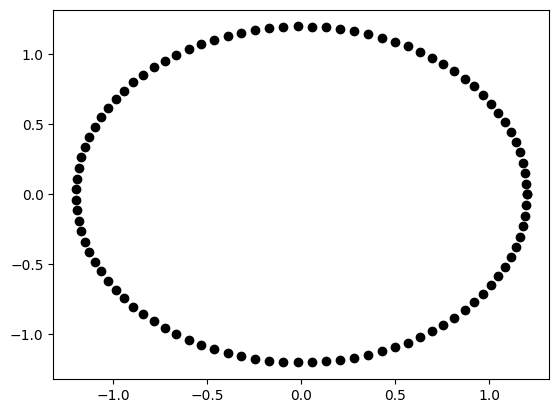

In [18]:
points_c=circle_points_torch(radius=1.2,num_points=100)
draw_p(points_c)


In [19]:
def get_borders(points):
    min_x=torch.min(points[:,0])
    max_x=torch.max(points[:,0])
    min_y=torch.min(points[:,1])
    max_y=torch.max(points[:,1])
    
    return (min_x,max_x,min_y,max_y)
    

def create_quadtree(dico,depth,points,borders,label):
    min_x=borders[0]
    max_x=borders[1]
    min_y=borders[2]
    max_y=borders[3]
    
    sep_x=min_x+torch.sqrt((max_x-min_x)**2)/2.0
    sep_y=min_y+torch.sqrt((max_y-min_y)**2)/2.0
    
    
    
    
    mask=(points[:,0]<= sep_x) & (points[:,1]> sep_y)
    hg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]> sep_y)
    hd= points[mask]
    mask=(points[:,0]<= sep_x) & (points[:,1]<= sep_y)
    bg= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]<= sep_y)
    bd= points[mask]
    
    
    gx=min_x
    gy=sep_y
    dx=sep_x
    dy=max_y
    if depth!=0:
        dico[label+"1"]=(depth,gx,gy,dx,dy,None)
    else:
        dico[label+"1"]=(depth,gx,gy,dx,dy,hg)
    
    if (hg.shape[0]!=0)and depth!=0:
        border=(gx,dx,gy,dy)
        create_quadtree(dico,depth-1,hg.clone(),border,label+"1")
    
    gx=sep_x
    gy=sep_y
    dx=max_x
    dy=max_y
    
    if depth!=0:
        dico[label+"2"]=(depth,gx,gy,dx,dy,None)
    else:
        dico[label+"2"]=(depth,gx,gy,dx,dy,hd)
    
    if (hd.shape[0]!=0)and depth!=0:
        border=(gx,dx,gy,dy)
        create_quadtree(dico,depth-1,hd.clone(),border,label+"2")
    
    gx=min_x
    gy=min_y
    dx=sep_x
    dy=sep_y
    
    if depth!=0:
        dico[label+"3"]=(depth,gx,gy,dx,dy,None)
    else:
        dico[label+"3"]=(depth,gx,gy,dx,dy,bg)
    
    
    if (bg.shape[0]!=0)and depth!=0:
        border=(gx,dx,gy,dy)
        create_quadtree(dico,depth-1,bg.clone(),border,label+"3")
    
    gx=sep_x
    gy=min_y
    dx=max_x
    dy=sep_y
    
    if depth!=0:
        dico[label+"4"]=(depth,gx,gy,dx,dy,None)
    else:
        dico[label+"4"]=(depth,gx,gy,dx,dy,bd)
    
    
    if (bd.shape[0]!=0) and depth!=0:
        border=(gx,dx,gy,dy)
        create_quadtree(dico,depth-1,bd.clone(),border,label+"4")
    
    
    
    
def draw_quadtree(dico):
    fig = plt.figure()
    
    for node in dico:
        depth,gx,gy,dx,dy,l_points=dico[node]
        
        if depth==0:
            draw_p(l_points)
        
        plt.plot([gx,dx],[gy,gy],color="blue")
        plt.plot([gx,dx],[dy,dy],color="blue")
        plt.plot([gx,gx],[dy,gy],color="blue")
        plt.plot([dx,dx],[dy,gy],color="blue")
    
    
    

In [20]:
dico=dict()
bord=get_borders(points_c)
create_quadtree(dico,6,points_c,bord,"")

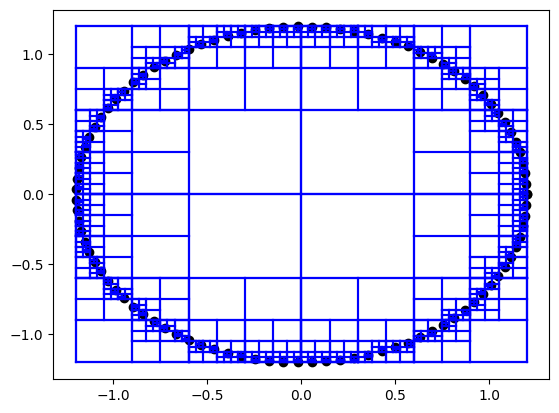

In [21]:
draw_quadtree(dico)

In [22]:
def B(t):
    if torch.abs(t)<0.5:
        return 1
    else:
        return 0

def f(x):
    
    return (B(x[0])*B(x[1]))**2

def f_rond(q,o_c,o_w):
    
    return (1/(o_w**3)) * f( (q-o_c)/o_w )
    

In [23]:
def gradient_field_approx(q,dico):
    """This function approximate the gradient of a node"""
    
    V_q=torch.zeros(2)
    
    for elem in dico:
        #not a leaf
        if dico[elem][0]!=0:
            continue
        #we're going to have a look to each sample of the dataset
        for s in dico[elem][-1]:
            #let's iterate over neighbours
            father_id=elem[:-1]
            
            for id_neigh in range(1,5):
                local_node=father_id+str(id_neigh)
                (_,gx,gy,dx,dy,_)=dico[local_node]
                
                sep_x=(gx+dx)/2.0
                sep_y=(gy+dy)/2.0
                
                o_c=torch.zeros(2)
                o_c[0]=sep_x
                o_c[1]=sep_y
               
                
                
                o_w=torch.sqrt((dx-gx)**2)
                
                
                alpha=torch.sqrt((s[:2]-o_c)**2)
                
            
                
                alpha=torch.exp(-alpha)
                
                
                V_q+=  f_rond(q,o_c,o_w) * s[2:]
           
 
    return V_q
                
                
            
        
        
    
    

In [24]:
n_p=100
vec_f=torch.zeros((n_p,n_p,2))

vec=torch.linspace(-1.25,1.25,n_p)


for i in range(n_p):
    for j in range(n_p):
        coor=torch.zeros(2)
        coor[0]=vec[i]
        coor[1]=vec[j]
        vec_f[i,j]=gradient_field_approx(coor,dico)

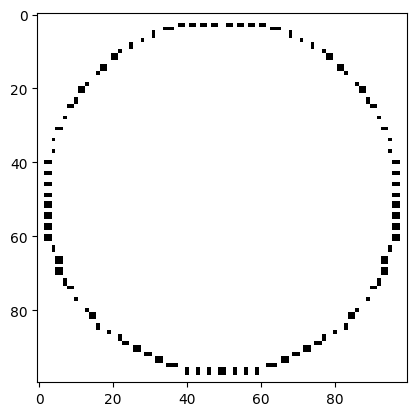

In [26]:
plt.imshow(torch.sqrt(vec_f[:,:,0]**2+vec_f[:,:,1]**2),cmap="Greys")